(propensity_scores)=
# Bayesian propensity scores for causal inference on observational data

:::{post} July, 2022
:tags: causal inference, quasi experimental design, regression, propensity scores, logistic regression
:category: intermediate
:author: Benjamin T. Vincent
:::

In [1]:
import arviz as az
import bambi as bmb
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc as pm
import seaborn as sns
from scipy.special import expit
from scipy.stats import bernoulli

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Introduction

Propensity scores are useful in quasi-experimental settings, where assignment of units to test or control groups were not random. Lack of [random assignment](https://en.wikipedia.org/wiki/Random_assignment) can be unavoidable in many situations:
- **Ethics:** it may not be ethically acceptible to randomly assign people to be exposed to some treatments, such as dry cleaning solvents, or living in close proximity to [fracking](https://en.wikipedia.org/wiki/Hydraulic_fracturing) operations.
- **Outside of your control:** it is not possible to randomly assign countries to [depart a large trading block](https://en.wikipedia.org/wiki/Brexit), nor is it always possible to randomly assign customers to an advertising exposure or no exposure groups.

Because of this non-random assignment, it is very likely that the test and control groups vary systematically. This makes a straight comparison between the outcome variable of interest problematic - are any differences in the outcome of interest due to the treatment or the other factors (aka [confounding variables](https://en.wikipedia.org/wiki/Confounding)) that influenced assignment to treatment or control conditions?

So how should we proceed? Should we give up in making any kind of statistical or causal claims about the effect of the treatment?  No! There are a range of things we can do, and this notebook focuses on the use of propensity scores.

In this notebook we will:
- Introduce a dataset alongside a the true causal DAG with counfounding variables.
- Show how the wrong causal model (ignoring confounders) will lead to wrong estimates of treatment effects
- Provide the motivation for calculating propensity scores with a fully worked out example. One of the key features of this notebooks is that it demonstrates how to go beyond calculating point estimaated, and calculates a posterior distribution over propensity scores.
- Provide a brief overview of the different ways you can use propensity scores to correct for the selection biases in our data, including:
  - Matching
  - Stratification
  - Covariate-adjustment
  - Inverse-probability weighting

## Data

This example is loosely based upon the excellent video [An intuitive introduction to Propensity Score Matching](https://www.youtube.com/watch?v=ACVyPp1Fy6Y) by Doug McKee.

In [3]:
# df = pd.DataFrame(
#     {
#         "treatment": [1, 1, 1, 1, 0, 0, 0, 0, 0],
#         "infant_mortality": [10, 15, 22, 19, 25, 19, 4, 8, 6],
#         "docs_per_capita": [0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.04, 0.05, 0.04],
#         "poverty_rate": [0.5, 0.6, 0.7, 0.6, 0.6, 0.5, 0.1, 0.3, 0.2],
#     }
# )
# df


treatment_effect = 0.5
docs_per_capita = np.random.randn(50) + 2
poverty_rate = np.random.randn(50) + 2
treatment_propensity = expit(-docs_per_capita + poverty_rate)
treatment = bernoulli.rvs(treatment_propensity)
infant_mortality = 5 - docs_per_capita + poverty_rate + (treatment_effect * treatment)

# docs_per_capita -= np.min(docs_per_capita)
# poverty_rate -= np.min(poverty_rate)
# infant_mortality -= np.min(infant_mortality)

df = pd.DataFrame(
    {
        "docs_per_capita": docs_per_capita,
        "poverty_rate": poverty_rate,
        "treatment": treatment,
        "infant_mortality": infant_mortality,
    }
)

df

,docs_per_capita,poverty_rate,treatment,infant_mortality
0,2.140055,2.565787,0,5.425732
1,1.608693,1.533821,1,5.425128
2,1.689061,1.058091,0,4.369030
3,2.928286,0.756635,0,2.828349
4,2.918788,2.005919,0,4.087131
5,3.090428,1.707006,0,3.616578
6,2.318296,2.837185,1,6.018889
7,1.113680,0.952967,1,5.339287
8,3.423357,2.886112,1,4.962754
9,4.038741,1.363302,0,2.324561


/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


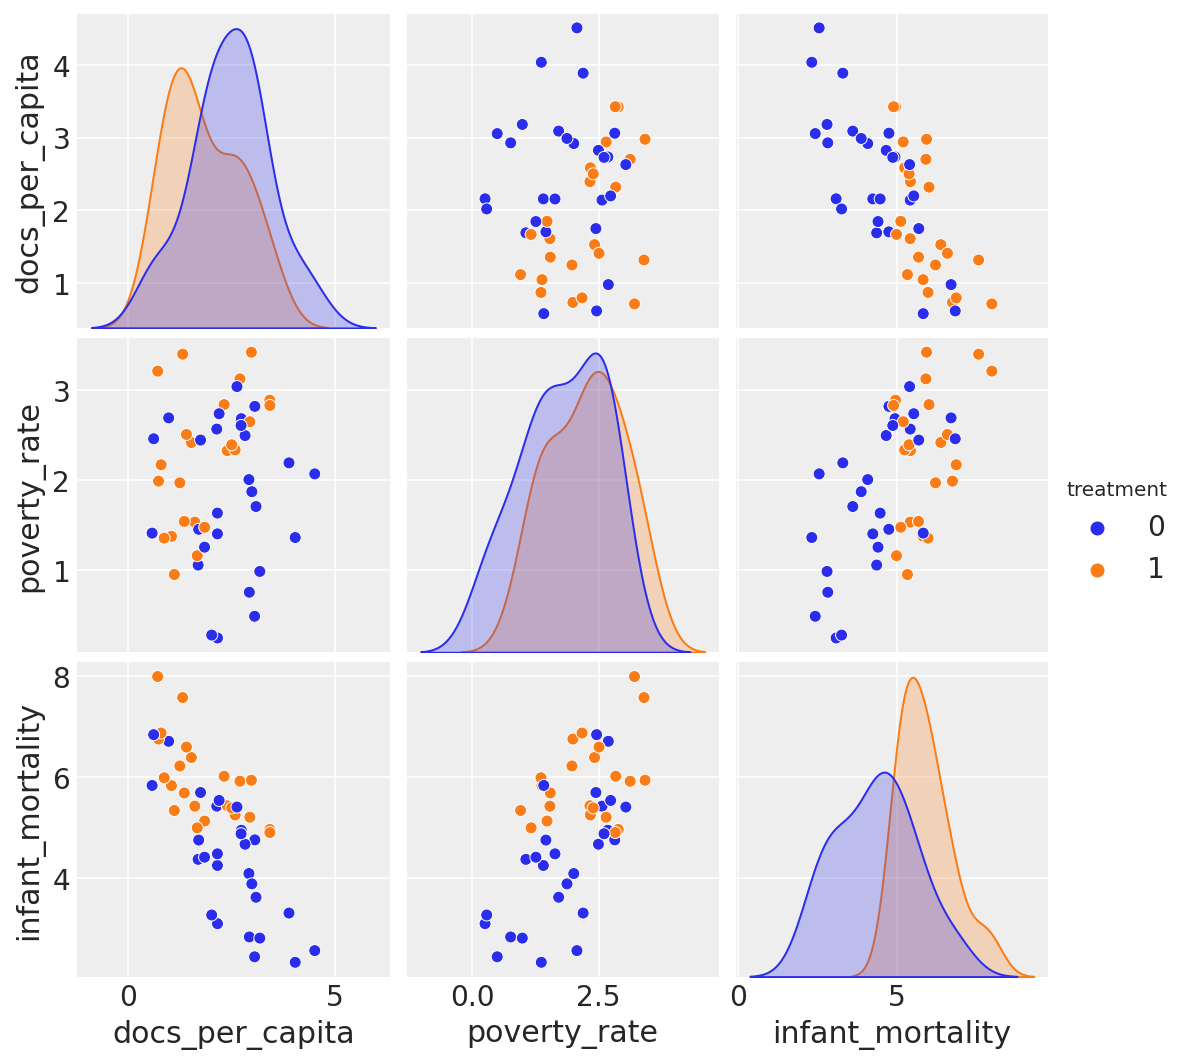

In [4]:
sns.pairplot(df, hue="treatment");

## Wrong causal explanation #1

The simplest approach we could take is to assume that infant mortality is causally influenced by the treatement, and the treatment alone. This causal DAG (see below) would suggest that we should simply look for differences in infant morality is different depending upon the treatment - so a simple linear model such as `infant_mortality ~ treatment`.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


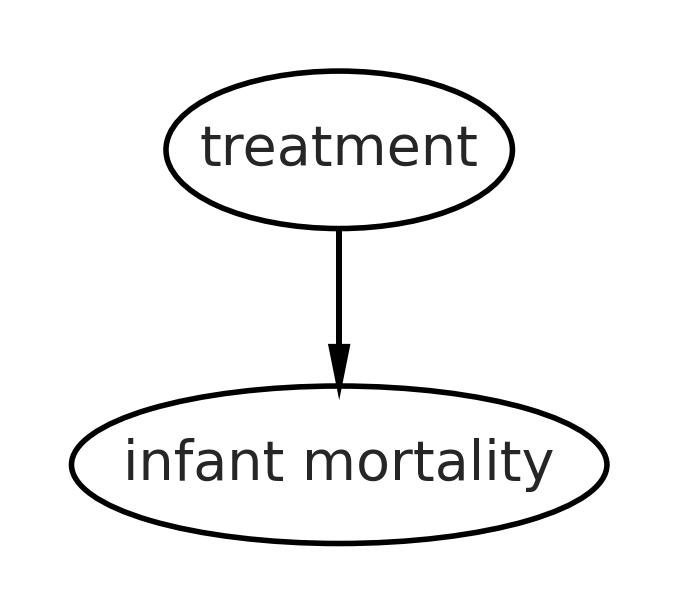

In [5]:
pgm = daft.PGM()
pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant mortality", 0, -1, aspect=3.4)
pgm.add_edge("t", "im")
pgm.render(dpi=200);

We could just look at the differences in infant mortality, split by treatment:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(treatment), infant_mortality_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


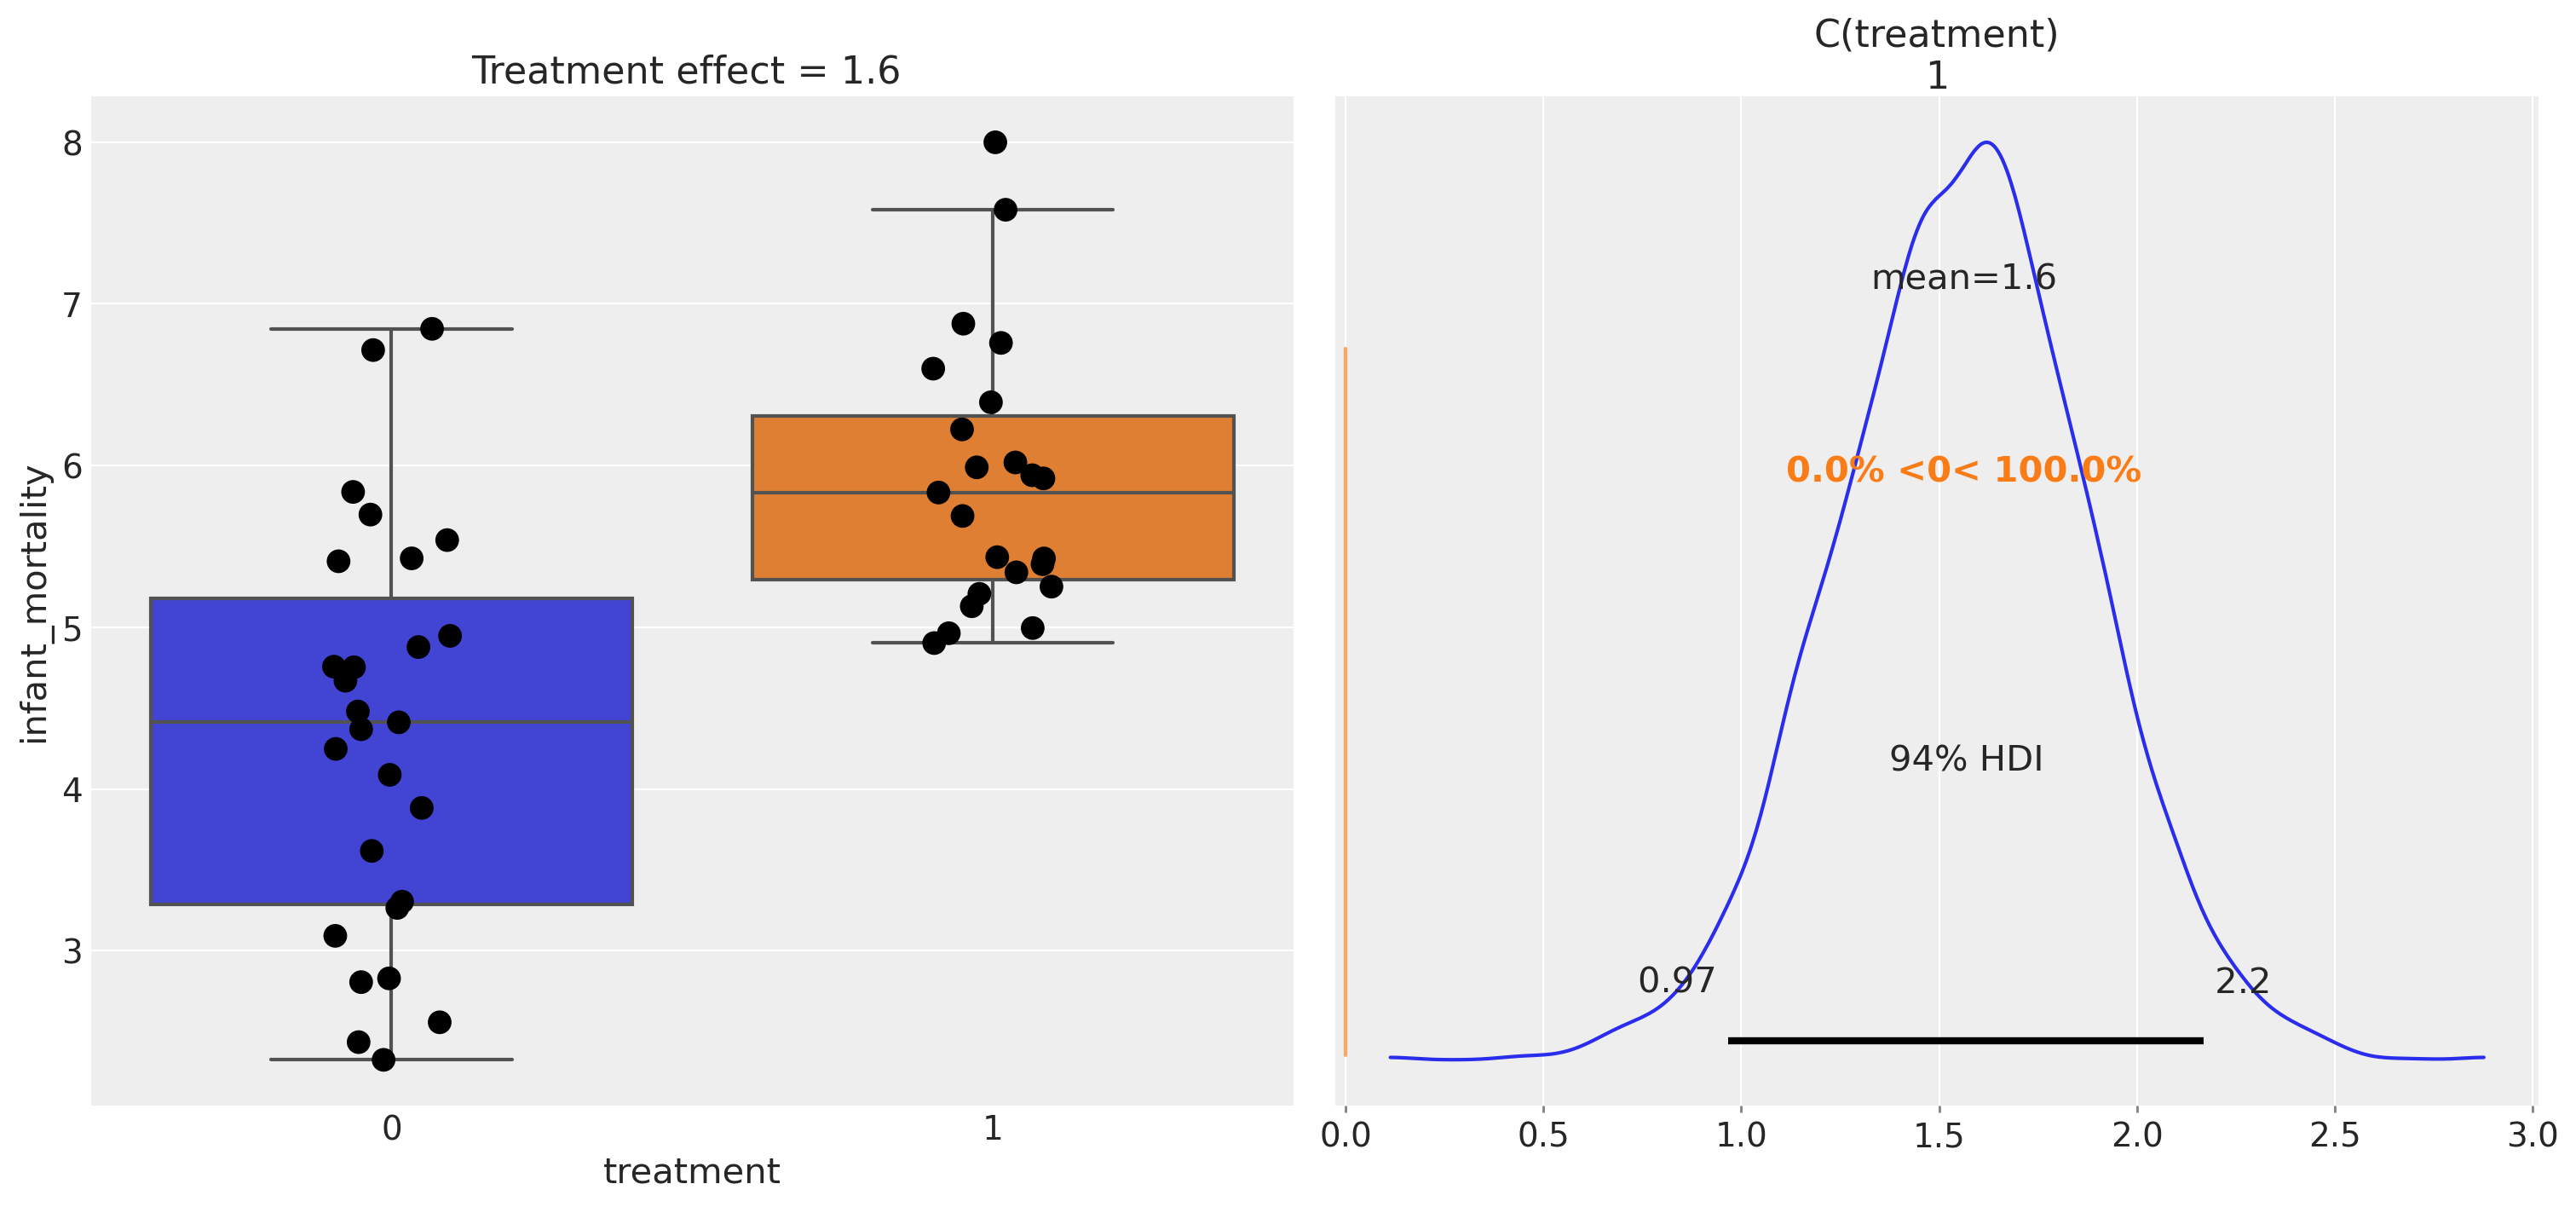

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# point estimate
treatment_effect = np.mean(df["infant_mortality"][df["treatment"] == 1]) - np.mean(
    df["infant_mortality"][df["treatment"] == 0]
)
sns.boxplot(x="treatment", y="infant_mortality", data=df, ax=ax[0])
sns.stripplot(
    x="treatment", y="infant_mortality", data=df, size=10, color="k", ax=ax[0]
)
ax[0].set(title=f"Treatment effect = {treatment_effect:.1f} ")

# bayesian estimate
model = bmb.Model("infant_mortality ~ C(treatment)", df)
fitted = model.fit(random_seed=RANDOM_SEED)
az.plot_posterior(fitted, var_names="C(treatment)", ref_val=0, ax=ax[1]);

So if this were the analysis we conducted then we would conclude that the treatment _increases_ infant mortality. And we would be flat out wrong!

Even if we calculated a posterior estimate of the treatment effect to obtain credible intervals, we would still be making the same fundamental mistake.

What else could we do?

If we had access to measures of infant mortality pre-treatment, then we could use a [differences in differences](https://en.wikipedia.org/wiki/Difference_in_differences) approach. But in this case, we do not have that data.

## Wrong causal explanation #2
Let's say a researcher did the analysis above and got this unexpected finding where the treatment effect was the opposite direction to expected. After some thinking, the researcher may realise that they had some selection bias issues and managed to get some data on some plausible confounding variables.

There is a very high likelihood that they would then run a multiple linear regression with the binary treatment variable _and_ the confounding variables as predictors in an attempt to "control for the confounders"

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


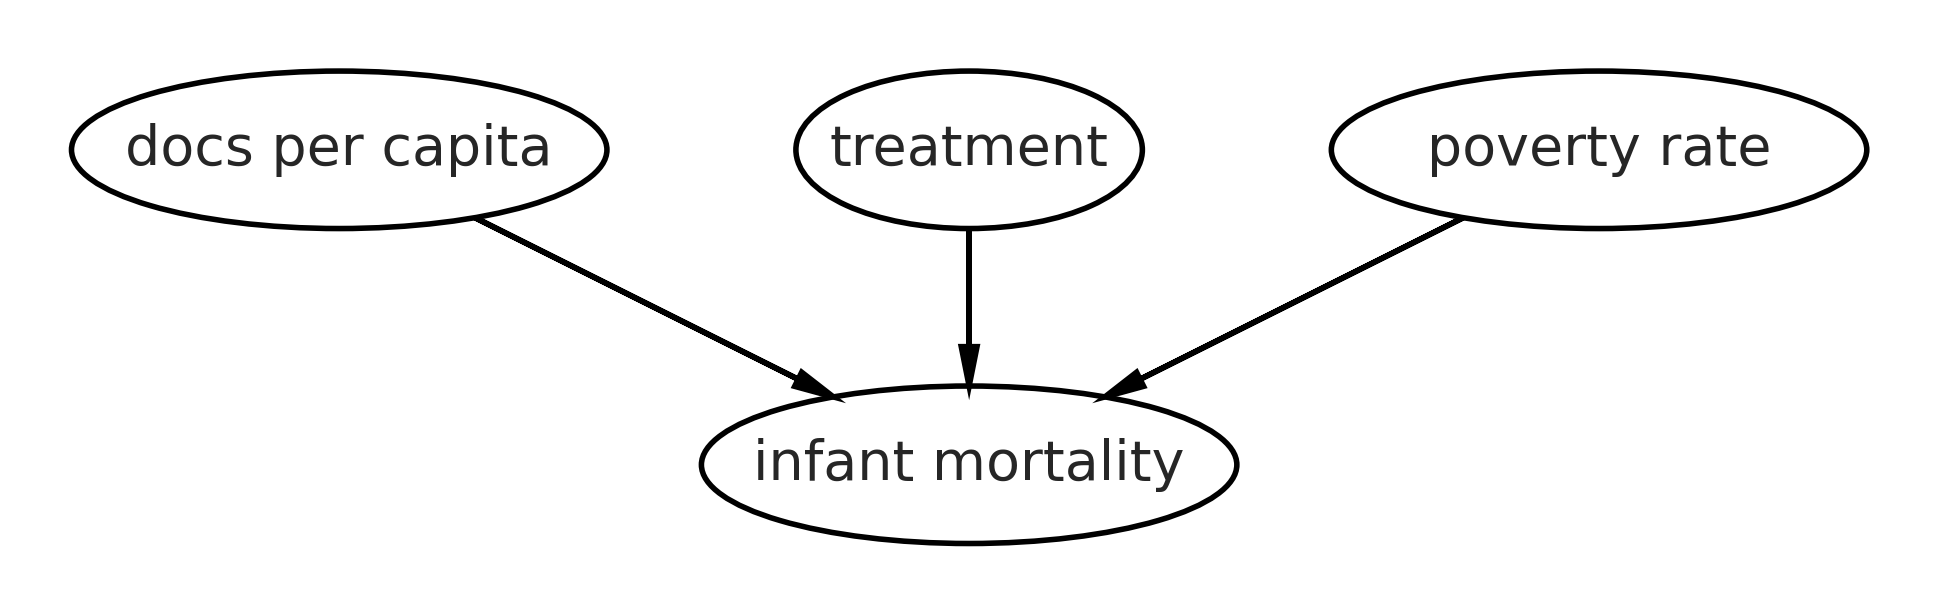

In [7]:
pgm = daft.PGM()

pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant mortality", 0, -1, aspect=3.4)
pgm.add_node("docs", "docs per capita", -2, 0, aspect=3.4)
pgm.add_node("pov", "poverty rate", 2, 0, aspect=3.4)

pgm.add_edge("t", "im")
pgm.add_edge("docs", "im")
pgm.add_edge("pov", "im")

pgm.render(dpi=200);

In [8]:
model2 = bmb.Model(
    "infant_mortality ~ C(treatment) + docs_per_capita + poverty_rate", df
)
model2

Formula: infant_mortality ~ C(treatment) + docs_per_capita + poverty_rate
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.0603, sigma: 12.0838)
    C(treatment) ~ Normal(mu: 0.0, sigma: 6.5988)
    docs_per_capita ~ Normal(mu: 0.0, sigma: 3.4768)
    poverty_rate ~ Normal(mu: 0.0, sigma: 4.1141)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.3155)

In [9]:
# fitted = model.fit(
#     tune=2000, init="adapt_diag", target_accept=0.9, random_seed=RANDOM_SEED
# )
fitted2 = model2.fit(random_seed=RANDOM_SEED, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(treatment), docs_per_capita, poverty_rate, infant_mortality_sigma]


/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:258: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:237: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:258: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:237: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


RuntimeError: Chain 1 failed.

In [10]:
az.plot_trace(fitted2);

NameError: name 'fitted2' is not defined

In [11]:
az.plot_posterior(fitted2, var_names="C(treatment)", ref_val=0);

NameError: name 'fitted2' is not defined

Well, that's pretty cool. Now the estimated effect size is negative, meaning that our treatment is estimated to _decrease_ infant mortality by XXXX.

## Better causal explanation - including confounding variables


Instead, we do have measures (conducted pre-treatment) of other properties of regions which may have influenced how they were assigned to the treatment or control condition.

We know in this case, our treatment was _not_ randomly assigned. Instead, we suspect through careful understanding of the particular problem, that regions with lower doctors per capita and higher poverty rates were more likely to be assigned to the treatment group. 

This would be in line with the heuristic of compassionate allocation of treatment to regions which needed it most. Although this would be statistically frustrating as it means we don't have random assignment.

All this means that our treatment and control groups are unequal in terms of their characteristics, as we can see in the plot below.


---

We can refine our causal explanation of the data to incorporate these confounding variables. These can be summarised in the following DAG:

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


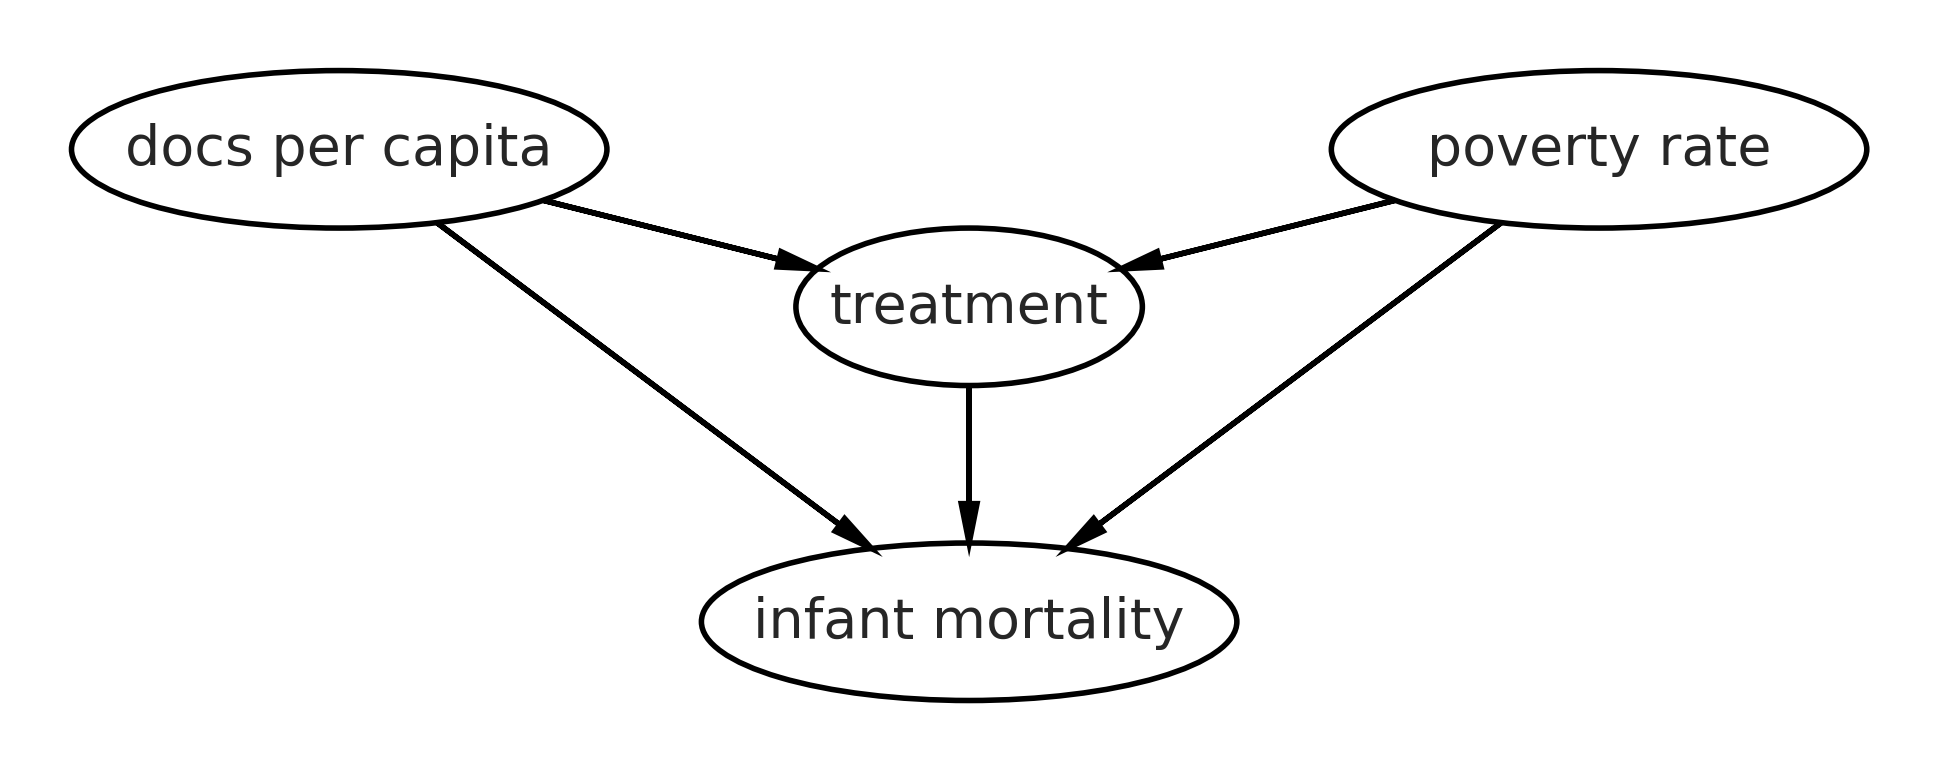

In [12]:
pgm = daft.PGM()

pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant mortality", 0, -1, aspect=3.4)
pgm.add_node("docs", "docs per capita", -2, 0.5, aspect=3.4)
pgm.add_node("pov", "poverty rate", 2, 0.5, aspect=3.4)

pgm.add_edge("t", "im")
pgm.add_edge("docs", "t")
pgm.add_edge("docs", "im")
pgm.add_edge("pov", "t")
pgm.add_edge("pov", "im")

pgm.render(dpi=200);

So in words what the DAG says is:
- exposure to treatment will causally inflence infant mortality
- but the number of doctors per captia causally influences both assignment to the treatment group and infant mortality levels
- and the poverty rate causally influences both the assignment to the treatment group and the infant mortality.

So we have doctors per capita and poverty rates confounding the treatment $\rightarrow$ infant mortality relationship.

There are different approaches we could take here, but our focus here is on propensity score matching.

Because we have a simple scenario here with two confounders, we can illustrate this in a plot quite simply:

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


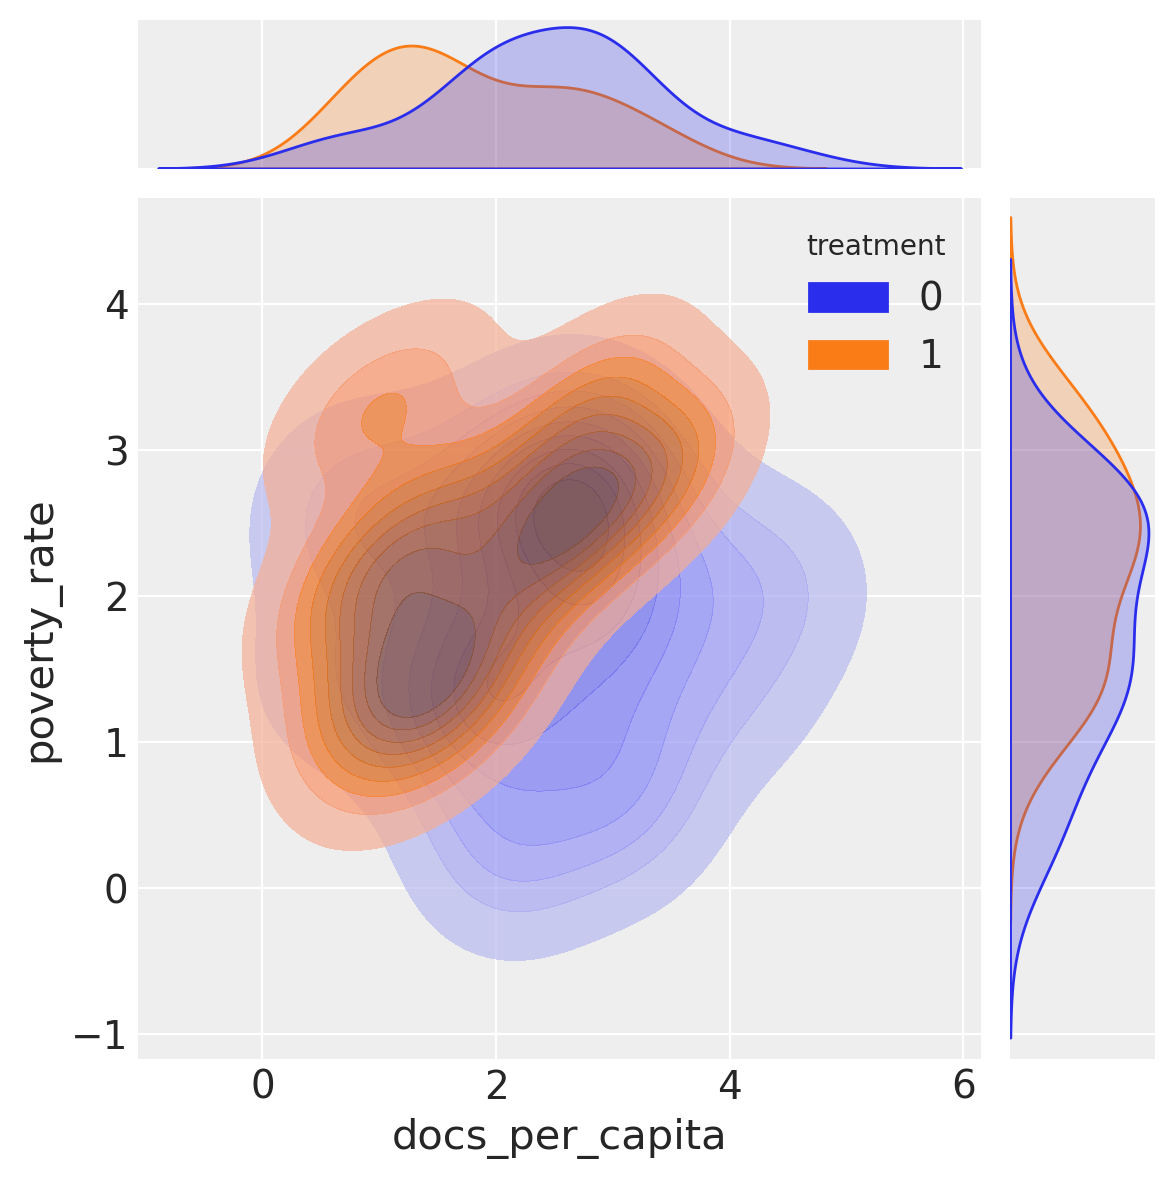

In [13]:
sns.jointplot(
    x="docs_per_capita",
    y="poverty_rate",
    hue="treatment",
    data=df,
    kind="kde",
    fill=True,
    alpha=0.7,
);

**NOTE:** If there was a sharp threshold in the characteristics of the regions being assigned to the treatment of control group, then we could consider analysing the data with the regression discontinuity design framework which we have covered here: {doc}`regression_discontinuity`.

## Bayesian propensity scores
In this section we will build a PyMC logistic regression model of the propensity. That is, the probability of inclusion in the treatment group. Importantly, we are not just running a regular logistic regression, we are running a Bayesian logistic regression which will get us posterior distributions over propensity scores.

In [14]:
y, X = patsy.dmatrices("treatment ~ docs_per_capita * poverty_rate", df)
labels = X.design_info.column_names
y, X = np.squeeze(np.asarray(y)), np.asarray(X)

COORDS = {"coeffs": labels, "obs": list(df.index)}

with pm.Model(coords=COORDS) as propensity_model:
    beta = pm.Normal("beta", 0, 1, dims="coeffs")
    propensity_score = pm.Deterministic(
        "propensity score", pm.math.invlogit(pm.math.dot(X, beta)), dims="obs"
    )
    pm.Bernoulli("infant_mortality", p=propensity_score, observed=y, dims="obs")
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


We can optionally inspect the traces, but there are no sampling issues apparent.

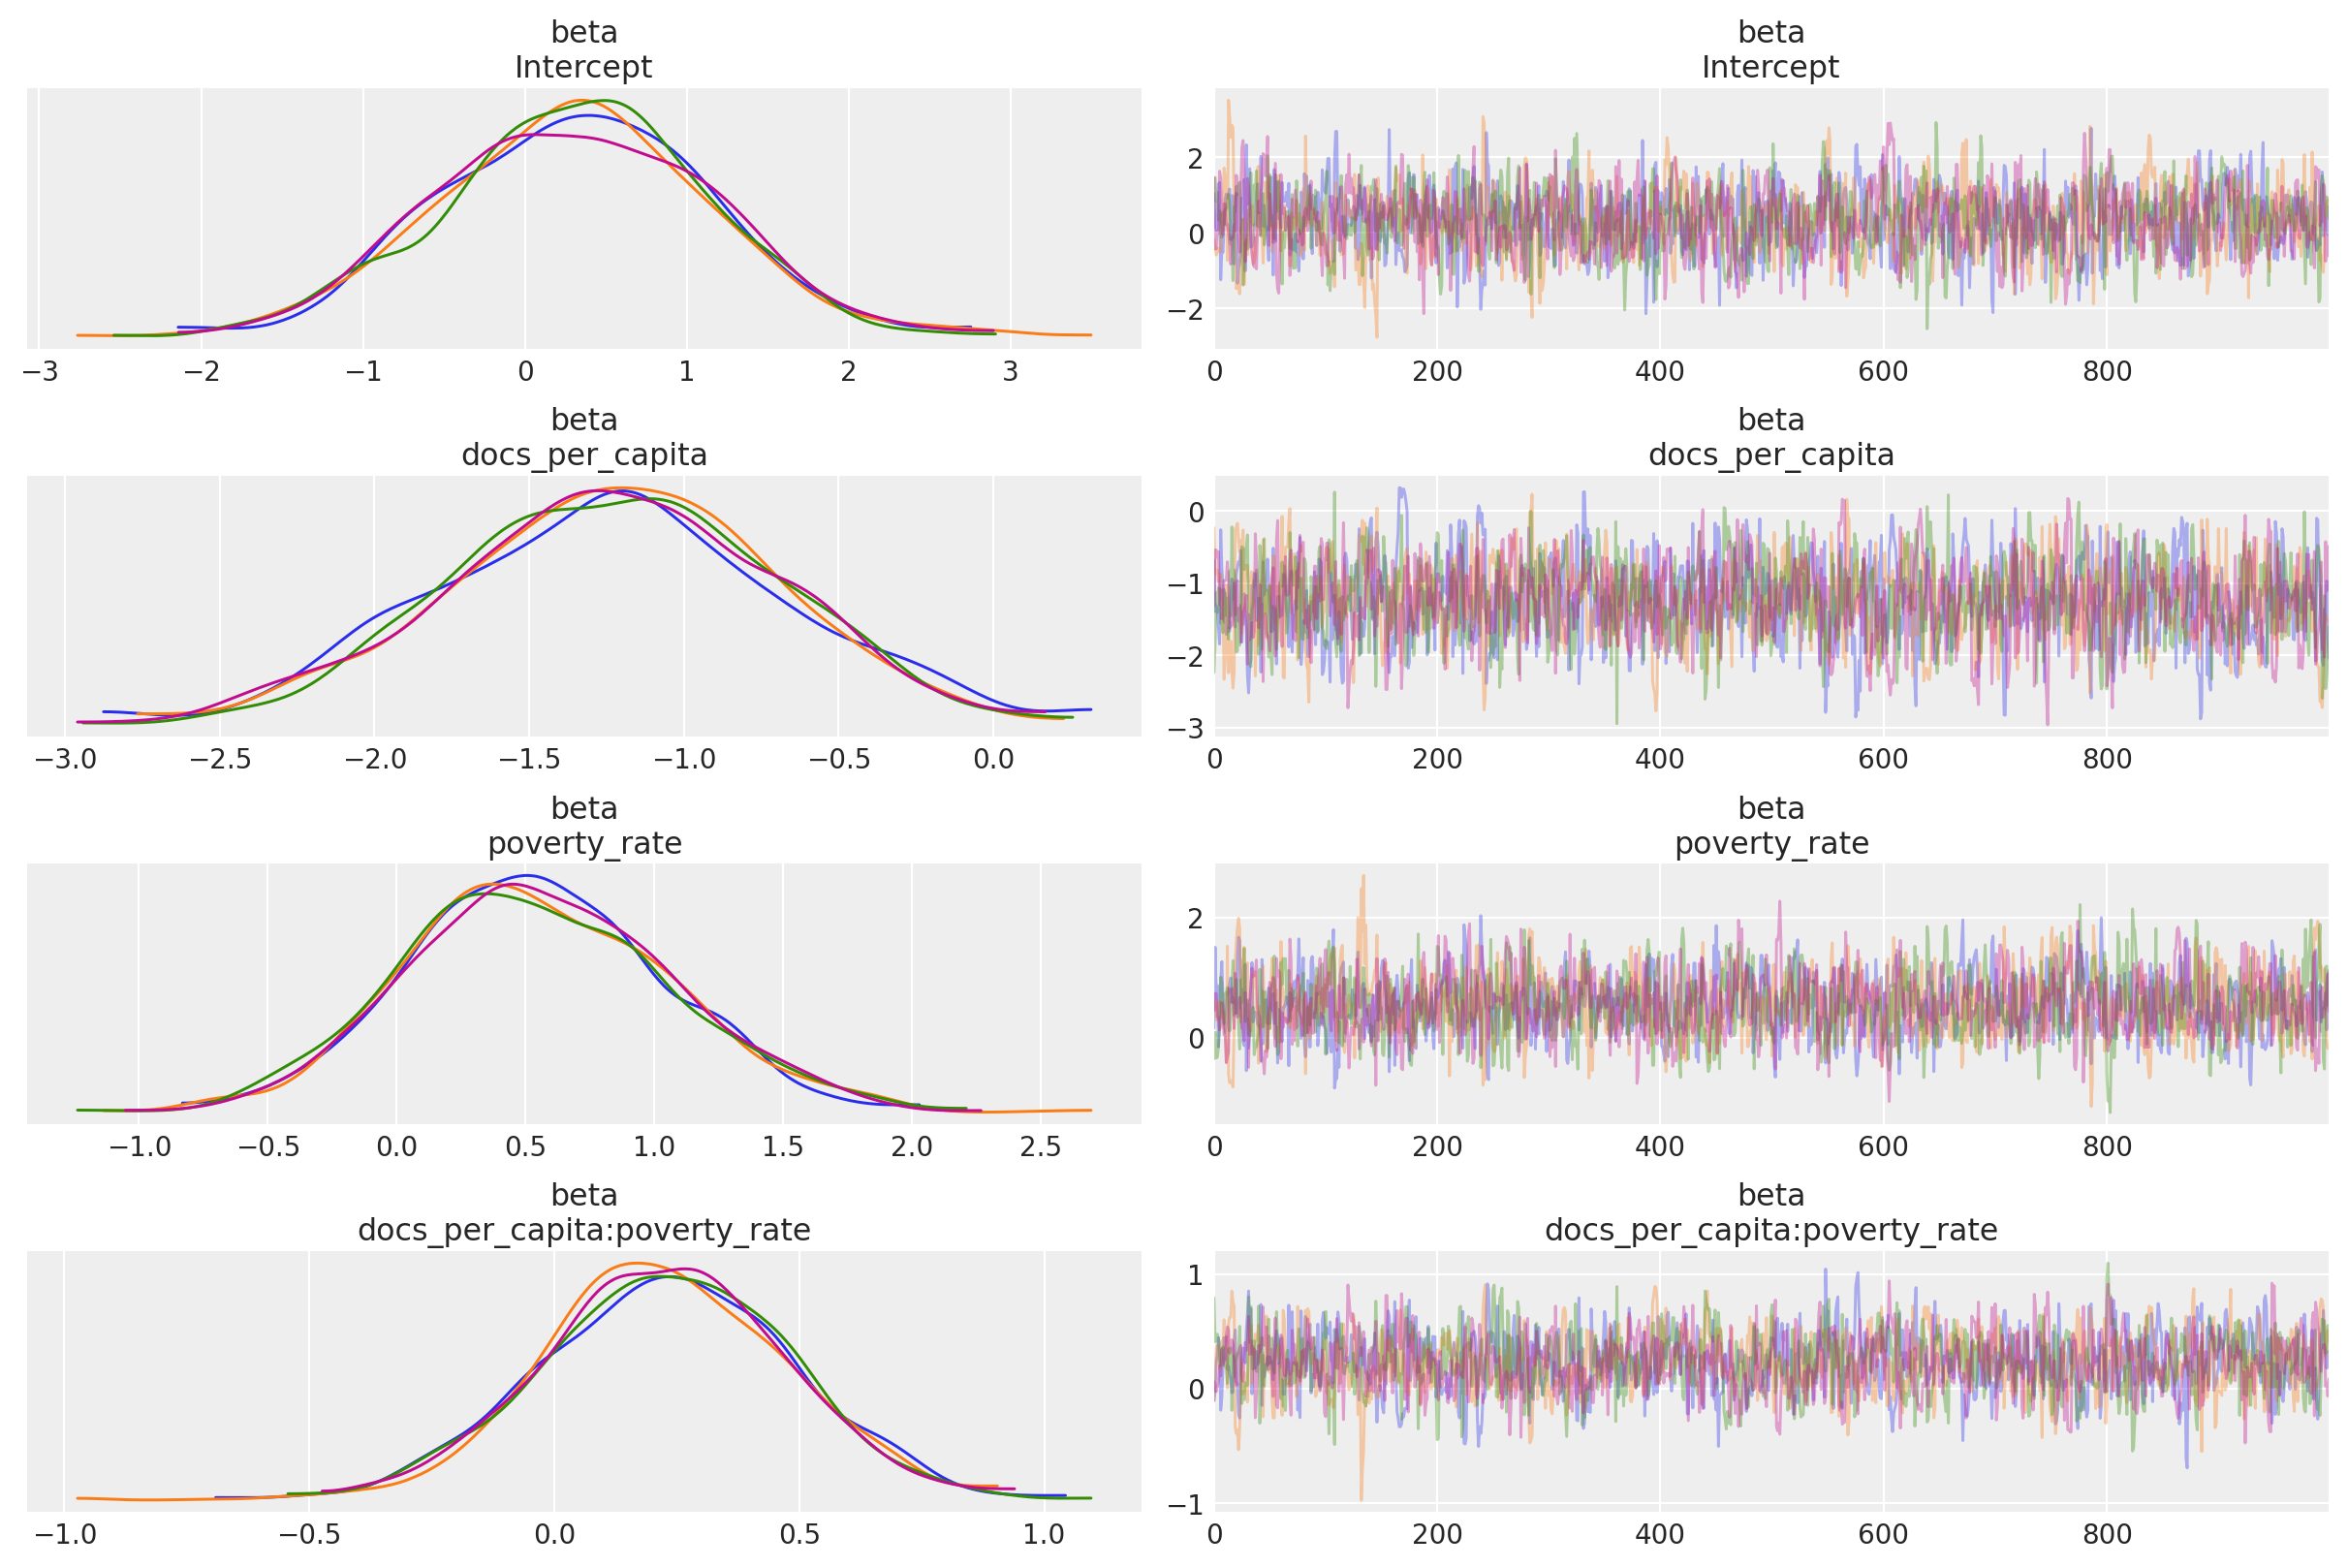

In [15]:
az.plot_trace(idata, compact=False, var_names="~propensity score");

And we can get a quick insight into the propensity scores by plotting the distribution of posterior mean propensity scores, split by treatment. This is good as there is some overlap in the propensity scores in both groups.

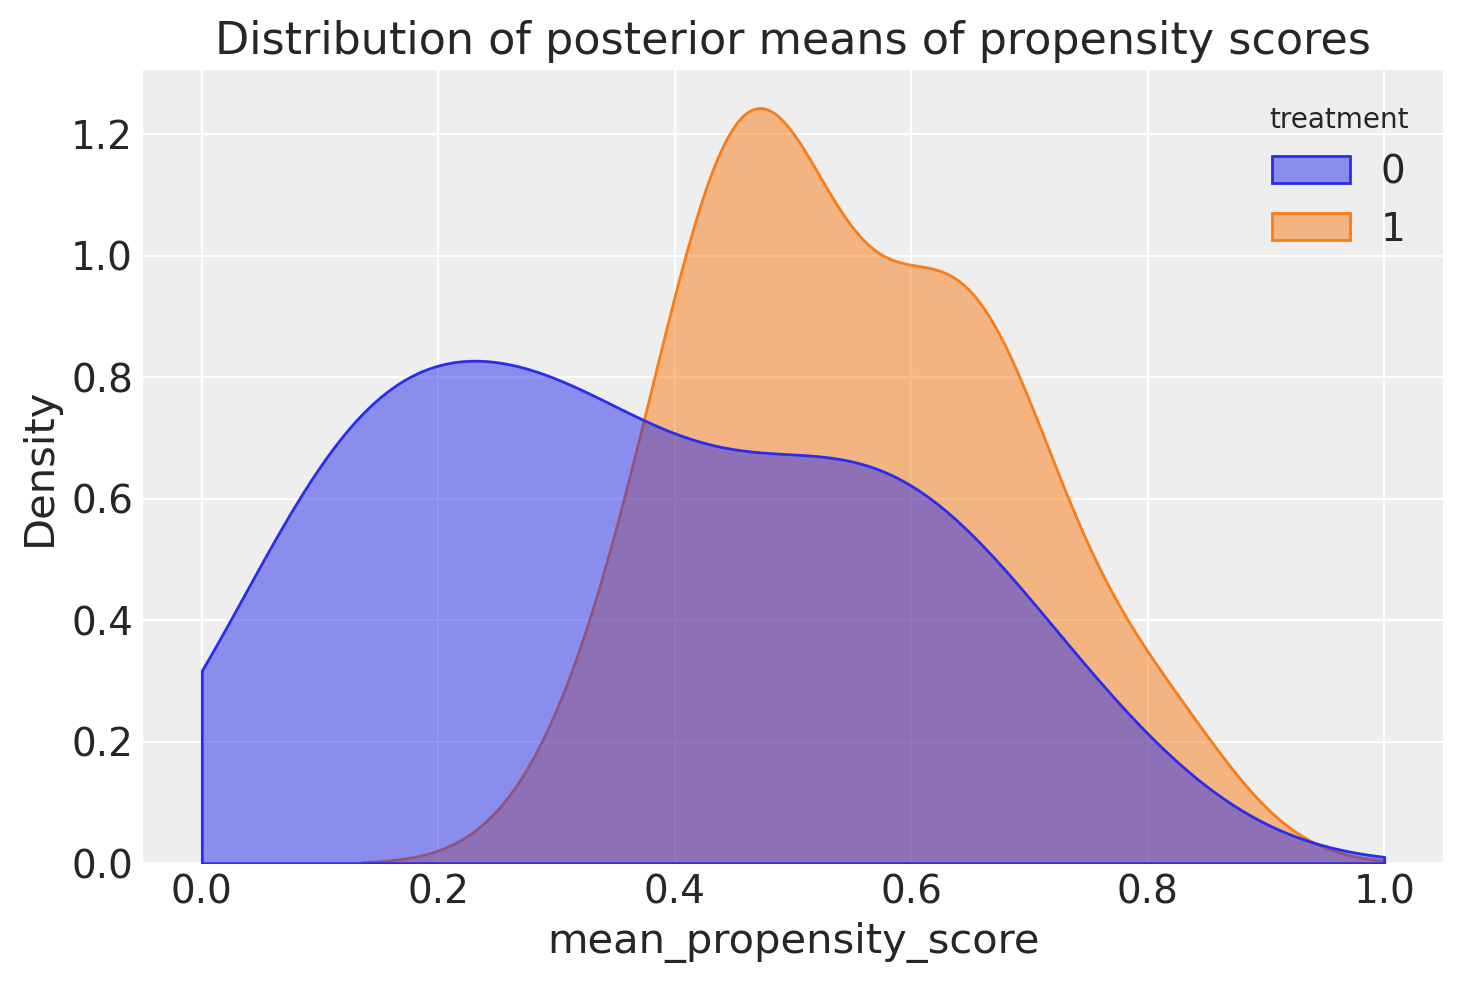

In [16]:
df["mean_propensity_score"] = idata.posterior["propensity score"].mean(
    dim=["chain", "draw"]
)

ax = sns.kdeplot(
    data=df,
    x="mean_propensity_score",
    hue="treatment",
    clip=(0, 1),
    fill=True,
    alpha=0.5,
)

ax.set(title="Distribution of posterior means of propensity scores");

## Matching 

Readers should be aware that matching is a broad topic with lots of complexities. What follows is a brief introduction to matching and matching via propensity scores as this is the core topic of this notebook. Alternative methods of matching are available and are potentially superior to propensity score matching:
* [Mehalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) matching
* [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) matching 
* Coarsened exact matching

### Why match?

Matching 'prunes' the dataset so as to reduce the imbalances in the dataset.

The effects of matching is to reduce model dependence (see figure below). When we have imbalanced data, the estimate of the treatment effect can vary greatly depending on the particular model. For example, depending on the data, the estimated effect size could change sign when we go from linear regression to quadratic regression. This is a real problem because a researcher may be biased to choose a model that happens to give a treatment effect with a desired sign. Fixing your imbalance through matching can reduce model dependence.

![](ho_et_al_2007.png)
> The left panel shows the full dataset of control (C) and treatment (T) observations. We can see that the groups are imbalanced, with the treatment group being more tightly clustered than the control group. Fitting a model like `Y ~ X + G` shows a positive treatment effect because the black solid line is above the grey solid line. But if we fit a polynomial model like `Y ~ X + X^2 + G` results in a negative treatment effect as the black (dashed) line is now below the gray (dashed) line. The treatment effect being so dependend upon the particular model is all but eliminated after matching (aka pruning). Figure from **Ho, D. E., Imai, K., King, G., & Stuart, E. A. (2007). Matching as nonparametric preprocessing for reducing model dependence in parametric causal inference. Political analysis, 15(3), 199-236.** https://imai.fas.harvard.edu/research/files/matchp.pdf

### What is matching?

The treatment effect for observation $i$ is equal to the difference between the true treatment effect for that observation (here observation $i$ was in the treatment group) and the outcome for unit $i$ had they not been treated.
$$
\text{treatment effect}_i = \underbrace{y_i(T=1)}_{\text{observed}} 
    - \overbrace{y_i(T=0)}^{\text{counterfactual}}
$$
The term on the right is an unobserved counterfactual.

Matching attempts to resolve this by estimating the counterfactual $y_i(T=0)$ with a well-matched control $y_j$ observations where we define "well-matched" by similarity in terms of the predictor variables (i.e. $X_i \approx X_j)$. Ideally we would be able to find a unit in our dataset that was not treated with _exactly_ the same predictor variables, but this is often too optimistic, so we make do with approximate matching.

This approach assumes we have all (or most) of the relevant confounding variables in our set of predictor variables.

In practice, we often want to know the _average_ treatment effect across units, so we can calculate the sample average treatment effect on the treated (SATT):

$$
\text{SATT} = \underset{i \in \{ T_i=1 \} }{\text{Mean}} (\text{treatment effect}_i)
$$

### Propensity score matching

[Propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching) simply executes matching based upon propensity scores. We have already calculated propensity scores above, so we can proceed with the matching algorith to construct our "pruned" or "synthetic control group". The logic of this is that we are trying to build an artifical control group which is more similar to the treatment group in terms of the confounders than the raw control group. Here, similarity is defined on the dimension of propensity.

```python   
matched_controls = [match(treated_propensity, untreated_propensity_list)
                    for treated_propensity in treated_propensity_list]
```

There are many different algorithms used for matching, and some are best in different situations. We are going to pick one at random and go with finding the closest value and use sampling with replacement.

In [17]:
def match(treated_propensity, untreated_propensity_list):
    return (np.abs(untreated_propensity_list - treated_propensity)).argmin()

In [29]:
# extract the MCMC samples of propensity scores
prop_scores = idata.posterior["propensity score"].stack(sample=["chain", "draw"]).data

# calculate quantities which are constant over samples
n_obs, n_samples = prop_scores.shape
outcome_varname = "infant_mortality"
treated_outcome_values = df[outcome_varname][df["treatment"] == True]
mean_of_treatment_group = np.mean(treated_outcome_values)

satt = []

for sample in range(n_samples):
    # extract propensity scores for treatment and control units
    treated_propensity_list = prop_scores[df["treatment"] == True, sample]
    untreated_propensity_list = prop_scores[df["treatment"] == False, sample]

    # do propensity score matching
    synth_control_idx = [
        match(treated_propensity, untreated_propensity_list)
        for treated_propensity in treated_propensity_list
    ]

    # calculate the SATT (sample average treatment effect on the treated)
    synthetic_control_outcome_values = df.loc[synth_control_idx, outcome_varname]
    unit_level_treatment_effect = (
        treated_outcome_values.to_numpy() - synthetic_control_outcome_values.to_numpy()
    )
    satt.append(np.mean(unit_level_treatment_effect))

satt = np.array(satt)

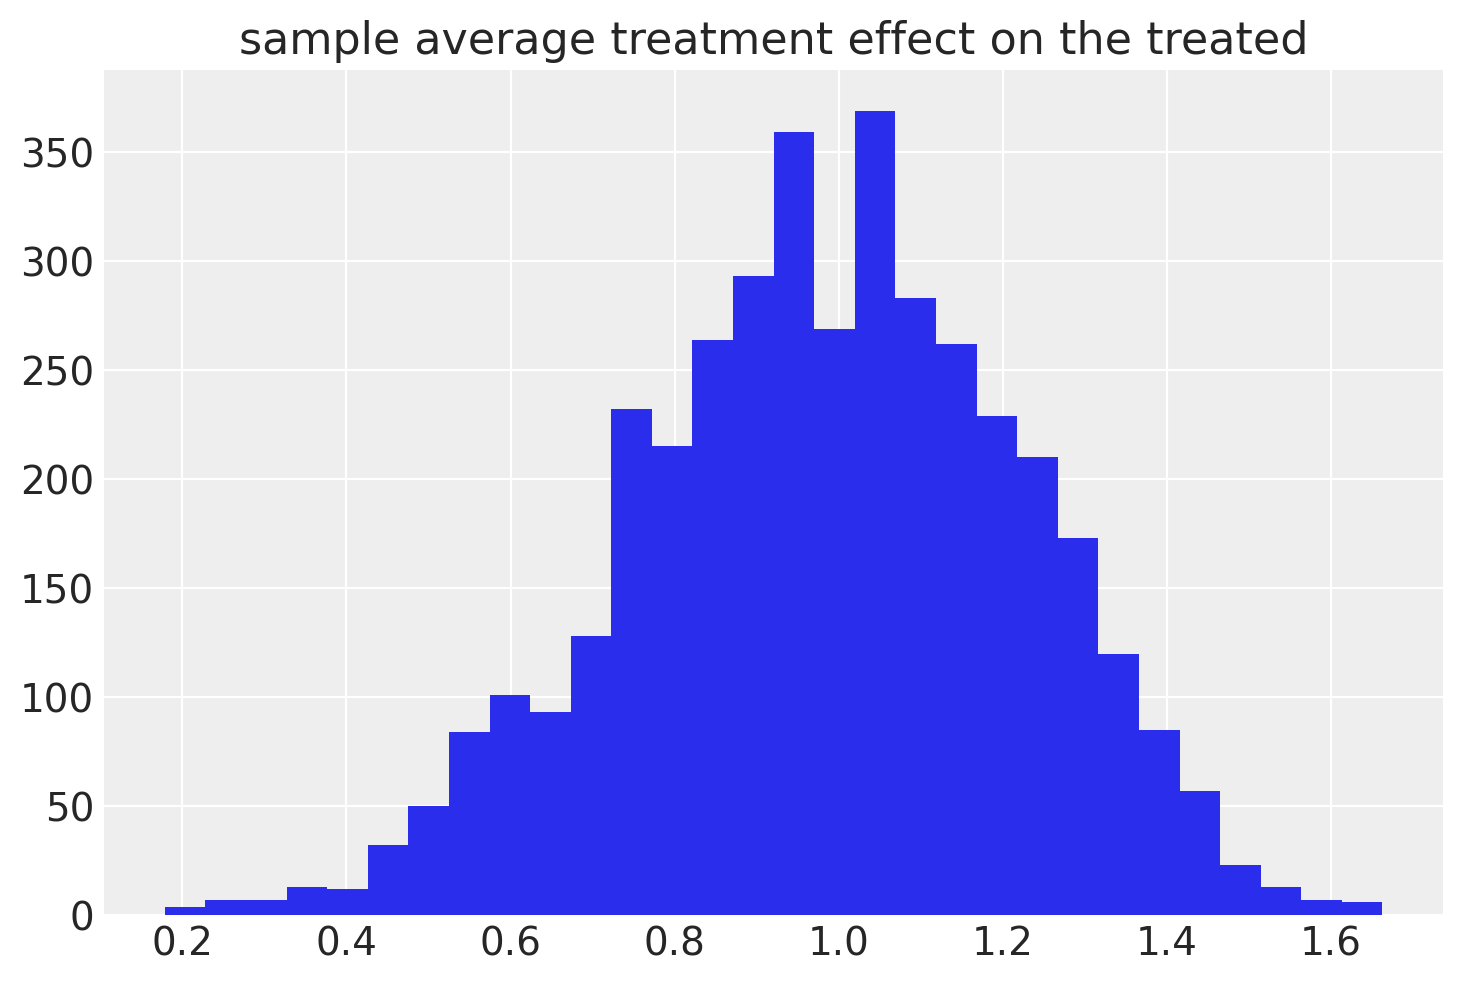

In [30]:
fig, ax = plt.subplots()

ax.hist(satt, bins=30)
ax.set(title="sample average treatment effect on the treated");

We can double check how well the matching procedure has worked by visualising propensity matching on just the posterior mean propensity scores.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


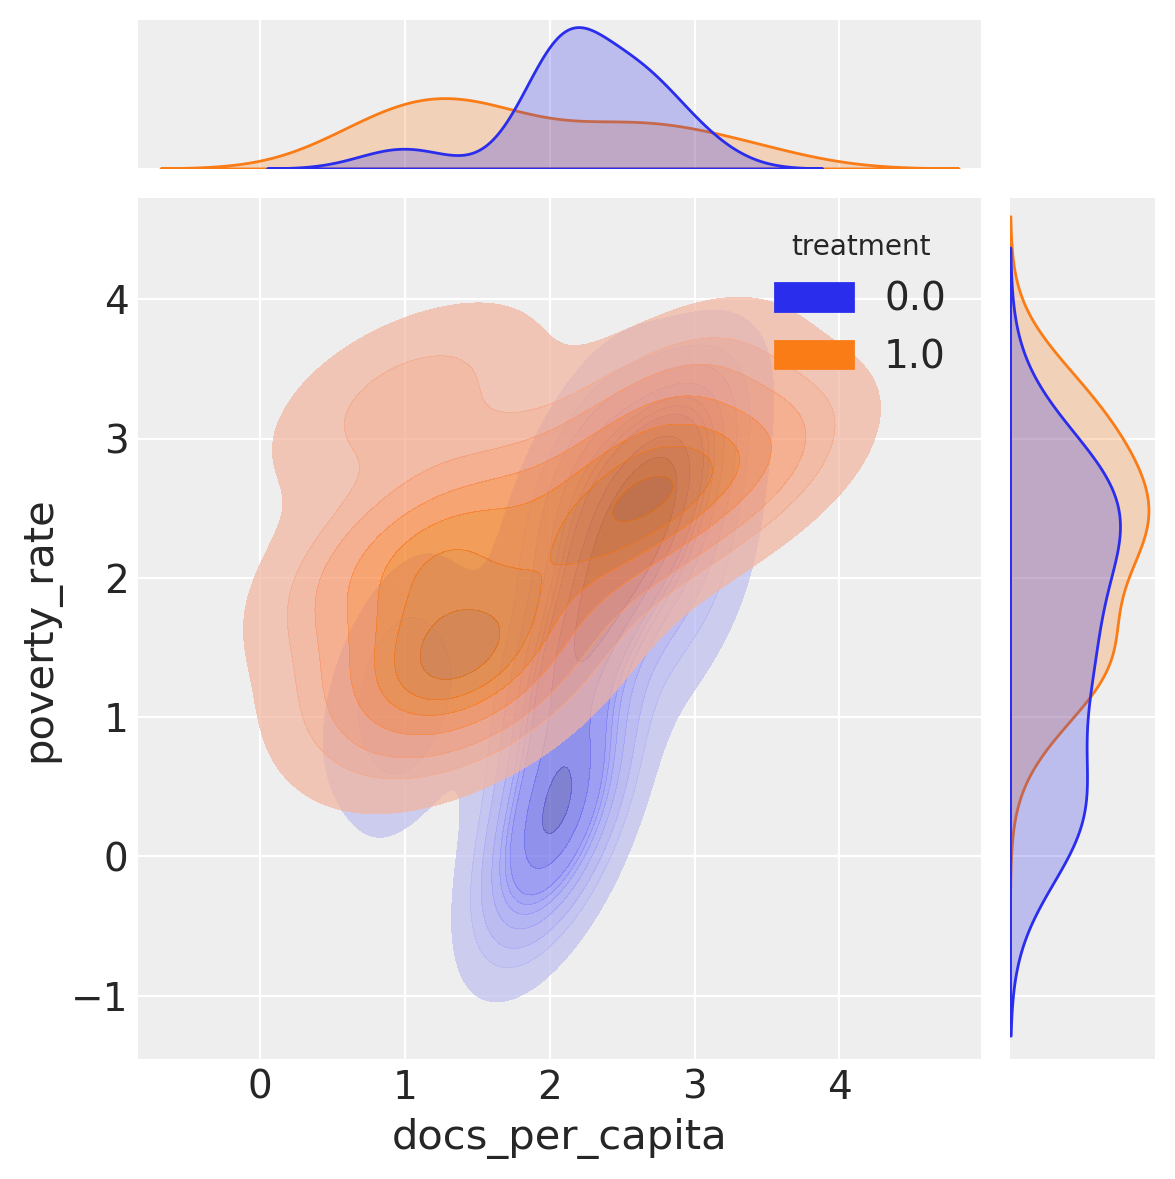

In [36]:
# For demonstration purposes, run the propensity score matching on the
# posterior means of the propensity scores

prop_scores = (
    idata.posterior["propensity score"]
    .stack(sample=["chain", "draw"])
    .mean(dim="sample")
)
treated_outcome_values = df[outcome_varname][df["treatment"] == 1]

treated_propensity_list = prop_scores[np.array(df["treatment"] == True)].data
untreated_propensity_list = prop_scores[np.array(df["treatment"] == False)].data

synth_control_idx = [
    match(treated_propensity, untreated_propensity_list)
    for treated_propensity in treated_propensity_list
]

# put everything into a DataFrame
n_treated = np.sum((df["treatment"] == 1))
df2 = pd.DataFrame(
    {
        "poverty_rate": np.append(
            df.loc[df["treatment"] == 1, "poverty_rate"],
            df.loc[synth_control_idx, "poverty_rate"],
        ),
        "docs_per_capita": np.append(
            df.loc[df["treatment"] == 1, "docs_per_capita"],
            df.loc[synth_control_idx, "docs_per_capita"],
        ),
        "treatment": np.append(np.ones(n_treated), np.zeros(n_treated)),
        "mean_propensity_score": np.append(
            df.loc[df["treatment"] == 1, "mean_propensity_score"],
            df.loc[synth_control_idx, "mean_propensity_score"],
        )
    }
)

# # plot
# fig, ax = plt.subplots(1, 2)

# sns.jointplot(
#     x="docs_per_capita",
#     y="poverty_rate",
#     hue="treatment",
#     data=df,
#     kind="kde",
#     fill=True,
#     alpha=0.7,
#     ax=ax[0]
# )
# ax[0].set(title="Original dataset")

sns.jointplot(
    x="docs_per_capita",
    y="poverty_rate",
    hue="treatment",
    data=df2,
    kind="kde",
    fill=True,
    alpha=0.7,
    # ax=ax[1]
);
# ax[1].set(title="Propensity matched dataset");

DESCRIBE THE PLOT HERE AND HOW PROPENSITY MATCHING IS ACTUALLY NOT A GREAT IDEA

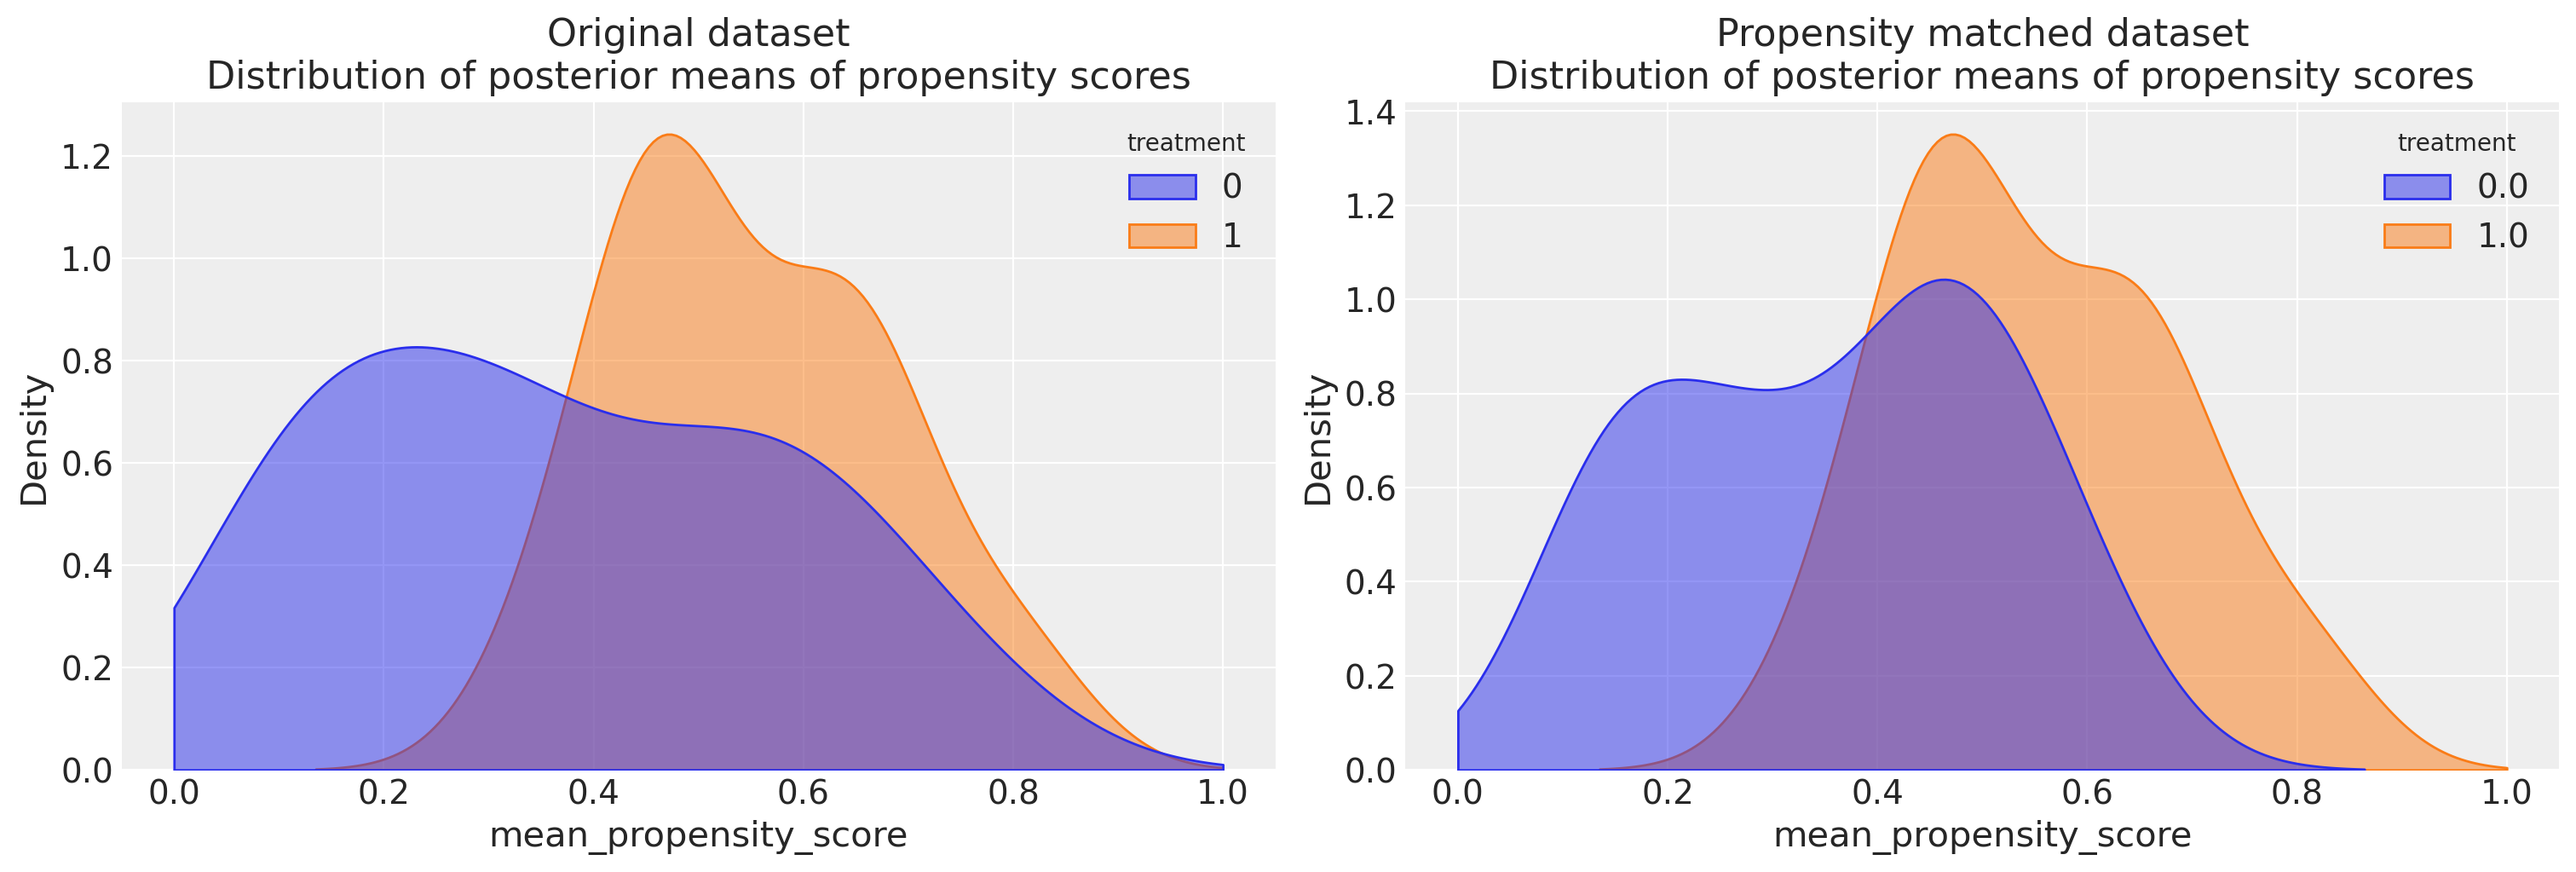

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(
    data=df,
    x="mean_propensity_score",
    hue="treatment",
    clip=(0, 1),
    fill=True,
    alpha=0.5, 
    ax=ax[0]
)

ax[0].set(title="Original dataset\nDistribution of posterior means of propensity scores");


sns.kdeplot(
    data=df2,
    x="mean_propensity_score",
    hue="treatment",
    clip=(0, 1),
    fill=True,
    alpha=0.5, 
    ax=ax[1]
)

ax[1].set(title="Propensity matched dataset\nDistribution of posterior means of propensity scores");

## Stratification

## Covariate-adjustment

## Inverse-probability weighting

## Further reading

* Gary King, "Why Propensity Scores Should Not Be Used for Matching": https://www.youtube.com/watch?v=rBv39pK1iEs
* https://pubmed.ncbi.nlm.nih.gov/24889820/

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2022.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

:::{include} ../page_footer.md
:::